In [9]:
from typing import List, Dict

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df, convert_numeric_to_float16
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *
from oop_functions.util_functions import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import itertools


In [10]:
cv_analytics_utils: Dict[str, CvAnalyticsUtil] = {}

In [11]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    ExperimentDataHelperSingleLabelScreenedFirst5,    
    # ExperimentDataHelperScreenedFirst5,
    # ExperimentDataHelperNotScreenedColsFirst5,
    # ExperimentDataHelperScreenedColsFirst5,
    # ExperimentDataHelperScreenedOrCancer,
    # ExperimentDataHelperScreened,
    # ExperimentDataHelperNotScreenedCols,
    # ExperimentDataHelperScreenedCols,
    # ExperimentDataHelperAll,
    # ExperimentDataHelperSingleLabelScreenedOrCancer,
    # ExperimentDataHelperSingleLabelScreened,
    # ExperimentDataHelperSingleLabelNotScreenedCols,
    # ExperimentDataHelperSingleLabelScreenedCols,
    # ExperimentDataHelperSingleLabelAll,
    # ExperimentDataHelperScreenedFirst5ca125AndBinary,
    # ExperimentDataHelperScreenedFirst5ca125Binary, 
    # ExperimentDataHelperScreenedFirst5ca125AndBinaryNoResult,

]

In [12]:
# TODO: save propagated source df so that propagation does not have to happen all the time

In [14]:
filesuffixes = []

In [15]:
years = [1]
num_folds=15
test_n_folds=15
train_size = 15000
# [None, 25, 50, 75, 100]
top_k_features = [None, 25, 35, 50]
for classifier_name, classifier in classifiers.items():
    for year in years:
        for experiment_data_helper_class in experiment_data_helpers:
            for top_k in top_k_features:
                label = f'cancer_in_next_{year}_years'
                # label = 'ovar_cancer'
                filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_{label}__{num_folds}_trials'
                select_cols = None
                if top_k:
                    select_cols = feature_importance_reader(filesuffix)[:top_k]
                    filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_top_{top_k}_features_{classifier_name}_{label}__{num_folds}_trials'
                print(filesuffix)
                filesuffixes.append(filesuffix)


_for_experiment_participants_screened_single_first_5_XGBClassifier_cancer_in_next_1_years__15_trials
_for_experiment_participants_screened_single_first_5_top_25_features_XGBClassifier_cancer_in_next_1_years__15_trials
_for_experiment_participants_screened_single_first_5_top_35_features_XGBClassifier_cancer_in_next_1_years__15_trials
_for_experiment_participants_screened_single_first_5_top_50_features_XGBClassifier_cancer_in_next_1_years__15_trials


_for_experiment_participants_screened_single_first_5_XGBClassifier_cancer_in_next_1_years__15_trials
Threshold: 0.006158298347145319


Cross-Validation measures:
+--------------------+------------+-------------+-----------+------------+
|                    |       mean |         std |       min |        max |
|--------------------+------------+-------------+-----------+------------|
| precision__class_0 | 0.999884   | 9.02918e-05 | 0.999714  | 1          |
| recall__class_0    | 0.909236   | 0.0104505   | 0.894853  | 0.928242   |
| f1-score__class_0  | 0.952378   | 0.00570058  | 0.944465  | 0.962653   |
| precision__class_1 | 0.00712569 | 0.000737984 | 0.005923  | 0.00832562 |
| recall__class_1    | 0.860185   | 0.109923    | 0.666667  | 1          |
| f1-score__class_1  | 0.0141322  | 0.00145562  | 0.0117532 | 0.0165138  |
| accuracy           | 0.909198   | 0.0103778   | 0.894848  | 0.928034   |
| auc                | 0.946339   | 0.0398853   | 0.875323  | 0.999133   |
+------------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


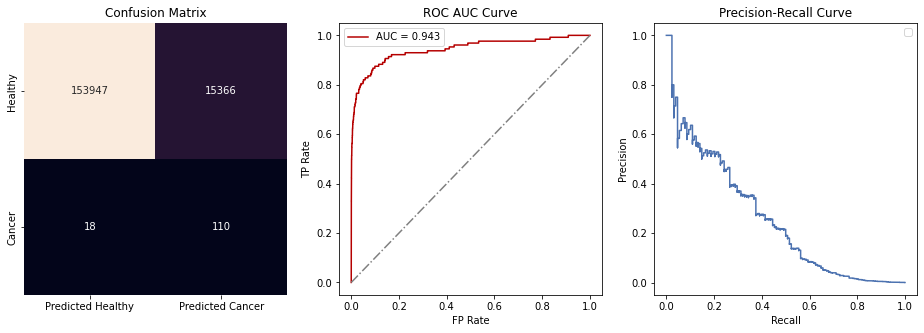

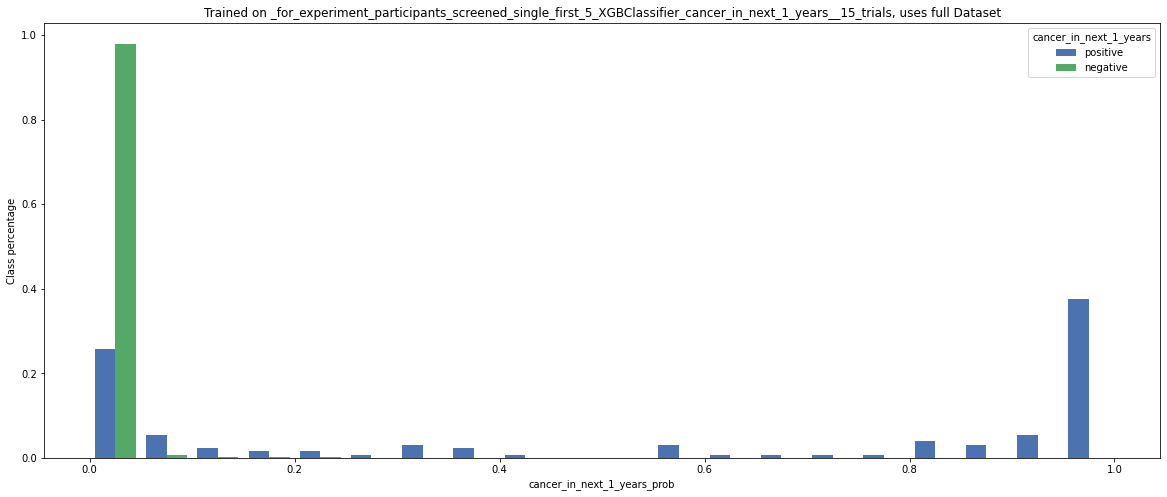

_for_experiment_participants_screened_single_first_5_top_25_features_XGBClassifier_cancer_in_next_1_years__15_trials
Threshold: 0.009398403577506542


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999915   | 8.15158e-05 | 0.999802   | 1          |
| recall__class_0    | 0.88815    | 0.0143768   | 0.866139   | 0.911879   |
| f1-score__class_0  | 0.940667   | 0.00801872  | 0.928268   | 0.953821   |
| precision__class_1 | 0.00607604 | 0.000652761 | 0.00494641 | 0.00724638 |
| recall__class_1    | 0.899074   | 0.0985547   | 0.75       | 1          |
| f1-score__class_1  | 0.0120686  | 0.001287    | 0.00982801 | 0.0143756  |
| accuracy           | 0.888158   | 0.0143034   | 0.866234   | 0.911765   |
| auc                | 0.957242   | 0.0339822   | 0.888594   |

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


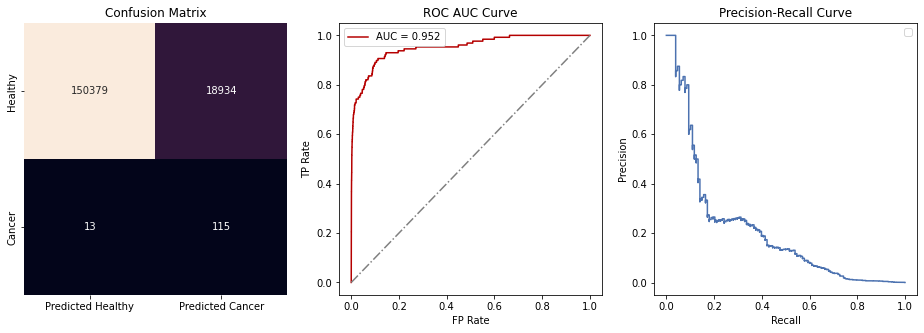

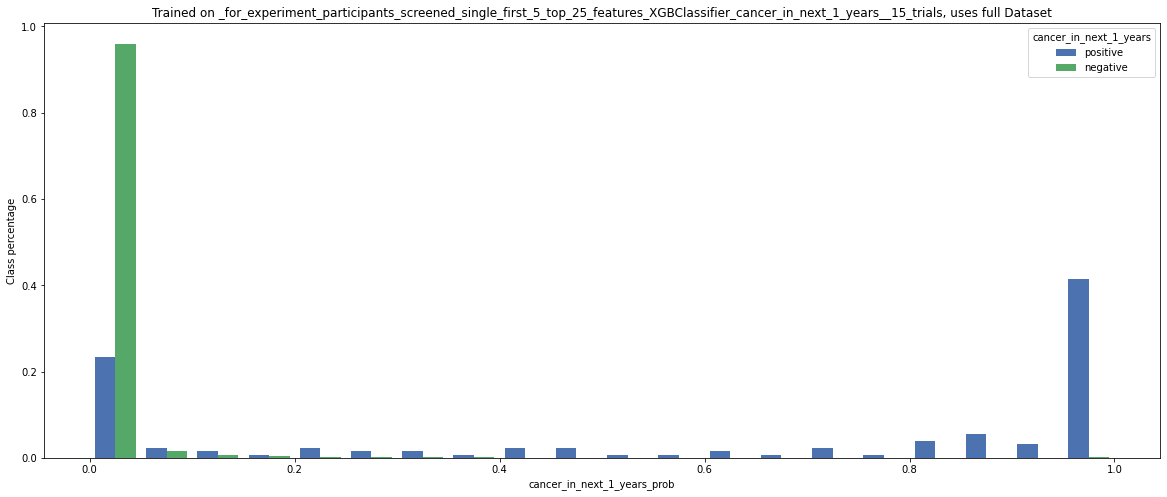

_for_experiment_participants_screened_single_first_5_top_35_features_XGBClassifier_cancer_in_next_1_years__15_trials
Threshold: 0.01567791774868965


Cross-Validation measures:
+--------------------+-----------+-------------+------------+-----------+
|                    |      mean |         std |        min |       max |
|--------------------+-----------+-------------+------------+-----------|
| precision__class_0 | 0.999894  | 8.54788e-05 | 0.999721   | 1         |
| recall__class_0    | 0.938295  | 0.00598583  | 0.928369   | 0.948329  |
| f1-score__class_0  | 0.968106  | 0.00316088  | 0.96281    | 0.973347  |
| precision__class_1 | 0.0105572 | 0.00133968  | 0.00859599 | 0.0132743 |
| recall__class_1    | 0.868519  | 0.105627    | 0.666667   | 1         |
| f1-score__class_1  | 0.0208564 | 0.00262652  | 0.0169972  | 0.0262009 |
| accuracy           | 0.938241  | 0.00592834  | 0.928338   | 0.948106  |
| auc                | 0.950284  | 0.0444154   | 0.863661   | 0.99718   |
+--------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


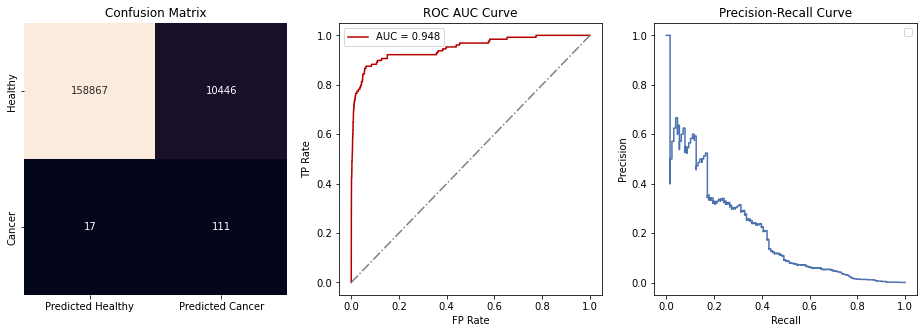

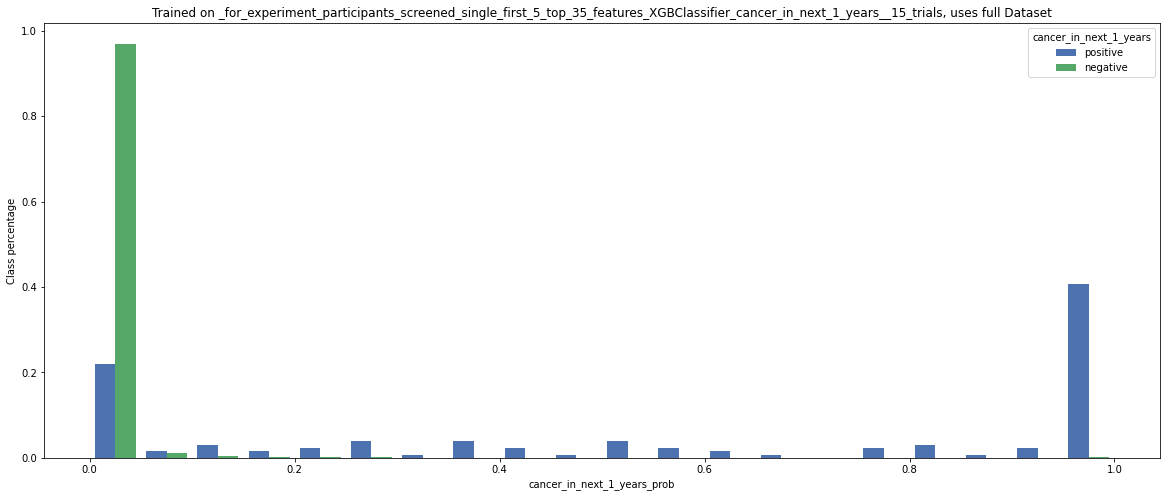

_for_experiment_participants_screened_single_first_5_top_50_features_XGBClassifier_cancer_in_next_1_years__15_trials
Threshold: 0.011354881338775158


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.999887  | 9.47677e-05 | 0.99972   | 1         |
| recall__class_0    | 0.937708  | 0.00849394  | 0.917282  | 0.949299  |
| f1-score__class_0  | 0.967781  | 0.00451528  | 0.956857  | 0.973902  |
| precision__class_1 | 0.0104072 | 0.00159918  | 0.0072904 | 0.0125174 |
| recall__class_1    | 0.859259  | 0.121406    | 0.625     | 1         |
| f1-score__class_1  | 0.0205601 | 0.0031408   | 0.0144404 | 0.0247253 |
| accuracy           | 0.937649  | 0.00843993  | 0.917341  | 0.949163  |
| auc                | 0.963542  | 0.0374442   | 0.853917  | 0.997957  |
+------------------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


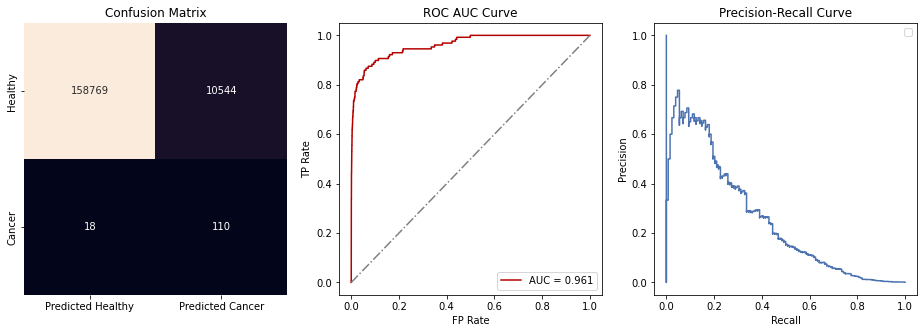

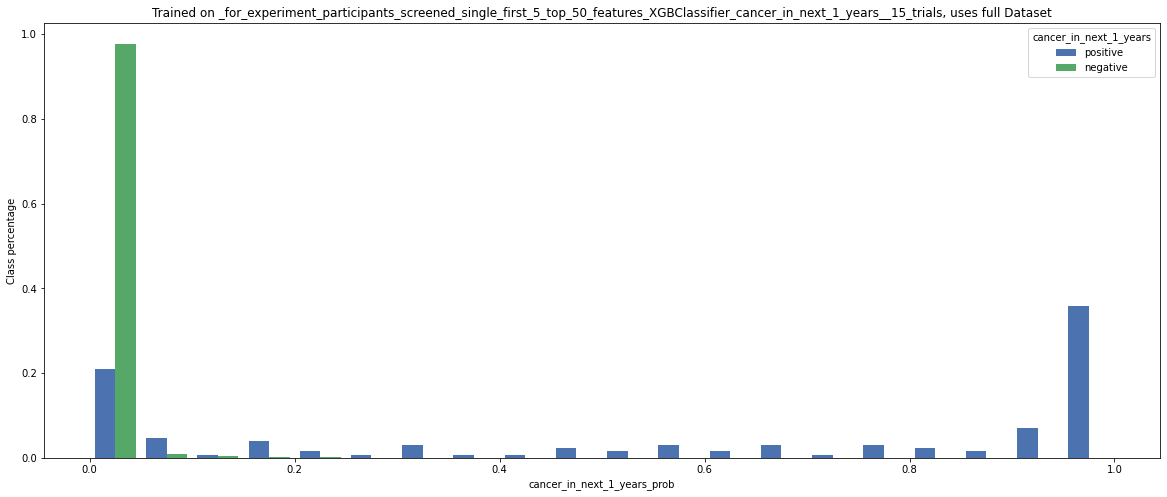

In [16]:
for filesuffix in filesuffixes:
    cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)
    print(filesuffix)
    cv_analytics_utils[filesuffix] = cv_analytics_util
    threshold = cv_analytics_util.get_optimal_operating_point()
    print(f"Threshold: {threshold}")
    cv_analytics_util.update_thresholds(threshold)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    label = cv_analytics_util.get_label()
    full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = label)
    plot_hist_side_by_side_for_class(full_dataset, label, f'{label}_prob', normalize = True, title=f'Trained on {filesuffix}, uses full Dataset')